In [11]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
from scipy.interpolate import interp1d
import pickle

import importlib.util
import sys

from cassL import camb_interface as ci
from cassL import user_interface as ui
from cassL import generate_emu_data as ged

In [12]:
''' This messiness is necessary to import scripts which are not installed and
which are not located in the cwd.'''

spec = importlib.util.spec_from_file_location(
    "andreap", "../andreap.py")
andreap = importlib.util.module_from_spec(spec)
sys.modules["andreap"] = andreap
spec.loader.exec_module(andreap)

In [13]:
# Get the latin hypercubes so that we know which values to use for our test
# cosmological configurations.

# Eventually this kind of code should go in a user_interface.py function,
# which will automatically take the requested set and the emulator version and
# correctly translate that into a set of loaded files. That requires, of course,
# that we stick more rigorously to a file naming scheme.

data_set = "test"

if data_set == "training":
    hc = np.load("../G_versions/hc_G6_pred_r1.npy",
        allow_pickle=True)
    samples = np.load("../G_versions/samples_G6_pred_r1.npy",
        allow_pickle=True)
    rescale_params = np.load("../G_versions/rescalers_G6_pred_r1.npy",
        allow_pickle=True)
elif data_set == "test":
    hc = np.load("../G_versions/hc_G6_test.npy",
        allow_pickle=True)
    samples = np.load("../G_versions/samples_G6_test.npy",
        allow_pickle=True)
    rescale_params = np.load("../G_versions/rescalers_G6_test.npy",
        allow_pickle=True)
    
standard_k = np.load("../standard_k.npy", allow_pickle=True)

In [14]:
# Load the emulator so that we can compare our results with, say, Andrea's

m = pickle.load(open("../G_versions/analyses/massive_emulator_G6_r1.nucomet", "rb"))

def inverse_transform(raw_prediction):
    return np.exp(raw_prediction * m.stdev + m.mu)

def nest(array):
    return np.array([np.array(array)])

In [15]:
# Select an individual cosmology to interrogate
test_index = 207
test_cosmology = hc[test_index]
test_pspec = samples[test_index]
best_h = rescale_params[test_index][0]
best_z = rescale_params[test_index][1]
print(best_h, best_z)

0.3700000000000001 0.03452481763128935


In [16]:
# Break the configuration into explicit labels
ombh2 = test_cosmology[0]
omch2 = test_cosmology[1]
ns = test_cosmology[2]
sigma12 = test_cosmology[3]
As = test_cosmology[4]
omnuh2 = test_cosmology[5]

In [17]:
# Get an emulator-readable cosmology object based off of these parameters
full_cosm = ged.build_cosmology(ombh2, omch2, ns, sigma12, As, omnuh2)

In [18]:
# What would we get if we called CAMB again on this configuration?
g_pspec, g_sigma12, g_rescale = \
    ged.interpolate_cell(full_cosm, standard_k,
    using_andrea_code=True)
g_z = g_rescale[1]
print("This is our approximation", g_sigma12)

nnu_massive: 0
nnu_massive: 0
nnu_massive: 0
nnu_massive: 0
nnu_massive: 1
This is our approximation 0.9890209260317093


In [19]:
print(g_rescale[0], g_rescale[1])

0.3700000000000001 0.034532729916700866


In [20]:
andrea_Pk = andreap.get_PK(ombh2, omch2, ns, omnuh2, best_h * 100, As)

In [21]:
# FOR THIS PARTICULAR TEST CASE (index 400, training set), h was not moved, and
# the following line is accurate
andrea_spectrum = andrea_Pk['mnu'].P(best_z, standard_k)

Text(0.5, 1.0, "Andrea's power spectrum")

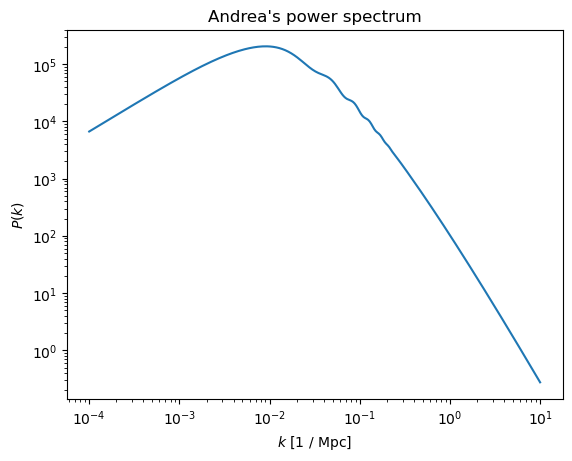

In [22]:
# What does Andrea's power spectrum look like here?
andrea_spectrum.shape
plt.loglog(standard_k, andrea_spectrum)
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('$P(k)$')
plt.title('Andrea\'s power spectrum')

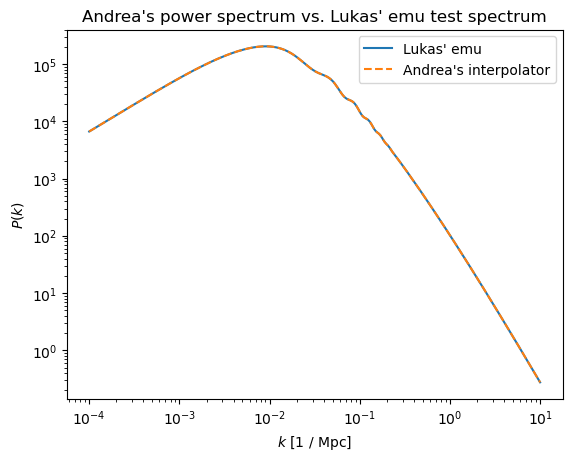

In [30]:
# Overplot comparison: Andrea's spectrum vs mine
plt.loglog(standard_k, g_pspec, label="Lukas' emu")
plt.loglog(standard_k, andrea_spectrum, label="Andrea's interpolator",
           linestyle='dashed')
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('$P(k)$')
plt.title("Andrea's power spectrum vs. Lukas' emu " + data_set + " spectrum")
plt.legend()

Text(0.5, 1.0, "Andrea's power spectrum vs. Lukas' emu test spectrum")

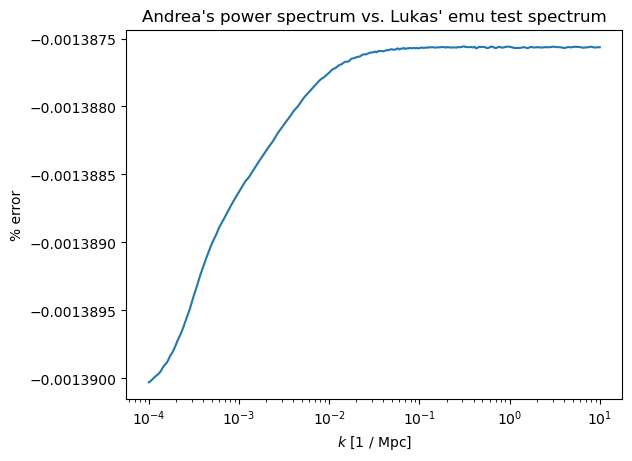

In [24]:
# Percent error comparison
plt.plot(standard_k,
         (g_pspec - andrea_spectrum) / andrea_spectrum * 100)
plt.xscale('log')
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('% error')
plt.title("Andrea's power spectrum vs. Lukas' emu " + data_set + " spectrum")
#plt.savefig("../../plots/emulator/debugging/Andrea_old_discrepancy.png")

In [25]:
# What happens if we, too, grab an interpolator object?
my_PI = ci.cosmology_to_PK_interpolator(
    full_cosm, redshifts=[best_z], kmax=10)
PI_result = my_PI.P(best_z, standard_k)

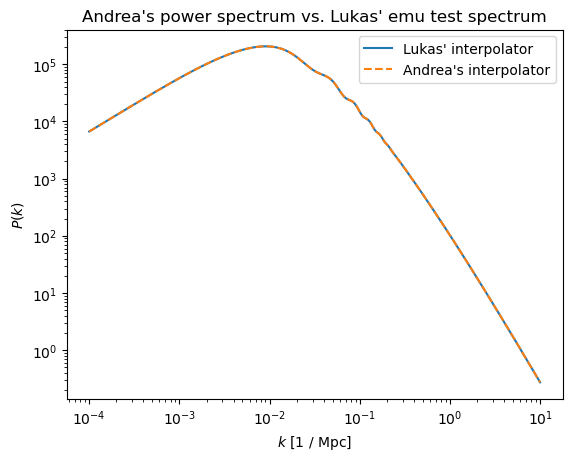

In [31]:
# Overplot comparison: Andrea's spectrum vs mine
plt.loglog(standard_k, PI_result, label="Lukas' interpolator")
plt.loglog(standard_k, andrea_spectrum, label="Andrea's interpolator",
           linestyle='dashed')
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('$P(k)$')
plt.title("Andrea's power spectrum vs. Lukas' emu " + data_set + " spectrum")
plt.legend()

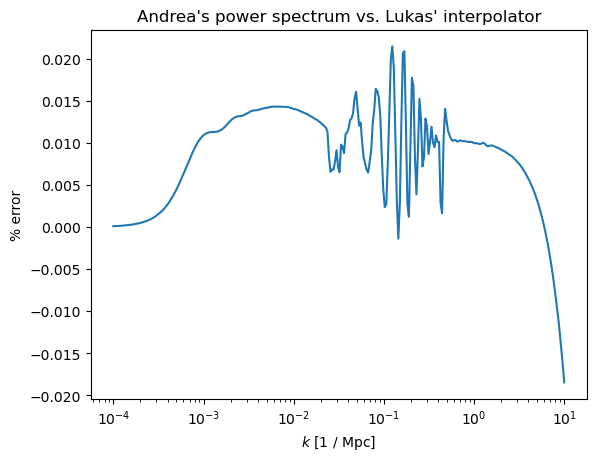

In [27]:
# Percent error comparison
plt.plot(standard_k,
         (PI_result - andrea_spectrum) / andrea_spectrum * 100)
plt.xscale('log')
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('% error')
plt.title('Andrea\'s power spectrum vs. Lukas\' interpolator')
plt.savefig("../../plots/emulator/debugging/Andrea_new_discrepancy.png")